In [1]:
#https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Postf4771a6d45c5b4a9afb7

In [2]:
# Library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm

import warnings
warnings.simplefilter('ignore')

In [3]:
# Config
INPUT = os.path.join("input")
OUTPUT = os.path.join("output")

TRAIN_FILE = os.path.join(INPUT, "train_v2.csv")
TEST_FILE = os.path.join(INPUT, "test_v2.csv")
SUB_FILE = os.path.join(INPUT, "sample_submission.csv")

exp_name = 'trial_seed_effect'
seed = 42

# plot style
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
plt.rcParams['axes.facecolor'] = 'EEFFFE'

In [4]:
# Data
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
sub = pd.read_csv(SUB_FILE)

In [5]:
print(train.shape)

(12240, 16)


# 前処理

In [6]:
target_col = ['pollen_utsunomiya', 'pollen_chiba', 'pollen_tokyo']
temp_col = ['temperature_utsunomiya', 'temperature_chiba', 'temperature_tokyo']
windd_col = ['winddirection_utsunomiya', 'winddirection_chiba', 'winddirection_tokyo']
winds_col = ['windspeed_utsunomiya', 'windspeed_chiba', 'windspeed_tokyo']
ppt_col = ['precipitation_utsunomiya', 'precipitation_chiba', 'precipitation_tokyo']

# 降雪かつ他の地域での飛散量も0以下の時0を代入
train.loc[((train['pollen_utsunomiya']==-9998)|(train['pollen_chiba']==-9998)|(train['pollen_tokyo']==-9998))&\
          (((train['pollen_utsunomiya']<=0)&(train['pollen_chiba']<=0)&(train['pollen_tokyo']<=0))), target_col] = 0
train = train[(train['pollen_utsunomiya']>=0)&(train['pollen_chiba']>=0)&(train['pollen_tokyo']>=0)]

In [7]:
train.describe()

,datetime,precipitation_utsunomiya,precipitation_chiba,temperature_utsunomiya,winddirection_utsunomiya,windspeed_utsunomiya,pollen_utsunomiya,pollen_chiba,pollen_tokyo
count,1.218300e+04,12183.000000,12183.000000,12183.000000,12183.000000,12183.000000,12183.000000,12183.000000,12183.000000
mean,2.018275e+09,0.134285,0.137569,12.737511,7.455471,3.127776,86.352294,29.590002,26.528934
std,9.997278e+05,0.811402,0.763562,7.783157,5.048083,1.920493,342.448286,100.339401,74.445145
min,2.017020e+09,0.000000,0.000000,-6.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.017061e+09,0.000000,0.000000,6.500000,3.000000,1.800000,0.000000,0.000000,0.000000
50%,2.018052e+09,0.000000,0.000000,12.800000,7.000000,2.700000,16.000000,8.000000,8.000000
75%,2.019042e+09,0.000000,0.000000,18.800000,11.000000,4.100000,57.000000,24.000000,24.000000
max,2.020033e+09,27.500000,21.500000,33.700000,16.000000,15.900000,12193.000000,4141.000000,2209.000000


In [8]:
# object(欠測) -> float
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train_df = train.replace('欠測', np.nan)
lgb_imp = IterativeImputer(
                       estimator=LGBMRegressor(num_boost_round=1000, random_state=seed),
                       max_iter=10, 
                       initial_strategy='mean',
                       imputation_order='ascending',
                       verbose=1,
                       random_state=seed)

train_df = pd.DataFrame(lgb_imp.fit_transform(train_df), columns=train_df.columns)
train_df[['winddirection_chiba', 'winddirection_tokyo']] = train_df[['winddirection_chiba', 'winddirection_tokyo']].round().astype(int)
train_df[['precipitation_tokyo', 'temperature_chiba', 'temperature_tokyo', 'windspeed_chiba', 'windspeed_tokyo']] = train_df[['precipitation_tokyo', 'temperature_chiba', 'temperature_tokyo', 'windspeed_chiba', 'windspeed_tokyo']].round(1)
train_df['datetime'] = train_df['datetime'].astype(int)
train = train_df
train

[IterativeImputer] Completing matrix with shape (12183, 16)
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[IterativeImputer] Change: 10.761506545250718, scaled tolerance: 2020033.124 
[Iterati

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0
3,2017020104,0.0,0.0,0.0,-1.1,4.4,1.8,1.0,15,1,4.1,3.1,1.4,0.0,12.0,0.0
4,2017020105,0.0,0.0,0.0,-1.2,4.1,1.5,2.0,14,14,3.7,3.4,0.9,0.0,32.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12178,2020033120,0.0,0.0,0.0,10.0,11.5,9.4,16.0,2,16,2.4,2.6,0.7,8.0,8.0,4.0
12179,2020033121,0.0,0.0,0.0,10.1,11.3,8.9,15.0,15,14,2.4,1.7,1.3,8.0,4.0,4.0
12180,2020033122,0.0,0.0,0.0,9.8,11.3,8.8,3.0,15,15,1.2,2.7,0.9,0.0,4.0,0.0
12181,2020033123,0.5,0.0,0.0,9.7,10.9,8.9,16.0,16,1,0.5,2.9,0.6,0.0,0.0,0.0


# モデルの設定
## Parameter

In [9]:
from sklearn.model_selection import (
    StratifiedKFold, 
    KFold, 
    GroupKFold,
    StratifiedGroupKFold,
)

from sklearn.metrics import mean_absolute_error as mae

import lightgbm as lgb

import os
import random
import tensorflow as tf
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# param
seed = 42
plot_mode=False

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Model

In [10]:
# LightGBM
class ModelLgb:
    def __init__(self, plot: bool, params: dict):
        self.model = None
        self.plot = plot
        self.params = params

    def fit(self, tr_x, tr_y, va_x=None, va_y=None):
        num_round = 100000
        early_stopping_rounds=100
        
        # validation
        if va_x is not None:
            lgb_train = lgb.Dataset(tr_x.values, tr_y)
            lgb_eval = lgb.Dataset(va_x.values, va_y)
            self.model = lgb.train(self.params, lgb_train, valid_sets=lgb_eval, num_boost_round=num_round, verbose_eval=0,
                                  callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)]
                                  )
        # No validation
        else:
            lgb_train = lgb.Dataset(tr_x, tr_y)
            self.model = lgb.train(self.params, lgb_train, num_boost_round=100, verbose_eval=0)

        # plot feature importance
        if self.plot:
            f_importance = np.array(self.model.feature_importance())
            df_importance = pd.DataFrame({'feat': tr_x.columns, 'importance': f_importance})
            df_importance = df_importance.sort_values('importance', ascending=True)
            plt.figure(figsize=(8,12))
            plt.barh('feat', 'importance', data=df_importance.iloc[-30:])
            plt.show()   
        
    def predict(self, x):
        pred = self.model.predict(x, num_iteration=self.model.best_iteration)
        return pred

In [11]:
train

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0
3,2017020104,0.0,0.0,0.0,-1.1,4.4,1.8,1.0,15,1,4.1,3.1,1.4,0.0,12.0,0.0
4,2017020105,0.0,0.0,0.0,-1.2,4.1,1.5,2.0,14,14,3.7,3.4,0.9,0.0,32.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12178,2020033120,0.0,0.0,0.0,10.0,11.5,9.4,16.0,2,16,2.4,2.6,0.7,8.0,8.0,4.0
12179,2020033121,0.0,0.0,0.0,10.1,11.3,8.9,15.0,15,14,2.4,1.7,1.3,8.0,4.0,4.0
12180,2020033122,0.0,0.0,0.0,9.8,11.3,8.8,3.0,15,15,1.2,2.7,0.9,0.0,4.0,0.0
12181,2020033123,0.5,0.0,0.0,9.7,10.9,8.9,16.0,16,1,0.5,2.9,0.6,0.0,0.0,0.0


# Trial Run
## Features
### 使う特徴量は以下の通り(全15特徴)

### 年(year)
### 月(month)
### 時刻(hour)
### 変換した降水量(precipitation) × 3
### 気温(temperature) × 3
### 風向(winddirection) × 3
### 風速(windspeed) × 3

In [12]:
#連続して降雨しなかった場合に1に近くなる

def zero_count(input_df, alpha = 0.05):
    df_count = []
    n_count = 0
    for i in range(len(input_df)):
        if input_df[i] < 0.5:
            n_count += 1
        else:
            n_count = 0
        df_count.append(n_count)
    df_count = np.tanh(np.array(df_count)*alpha)
    return df_count

def run_trial_feat(train, test):
    # 連結して全データに対して処理
    df = pd.concat([train, test]).reset_index(drop=True)

    # 時間特徴
    df['time'] = pd.to_datetime(df.datetime.astype(str).str[:-2])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['hour'] = df.datetime.astype(str).str[-2:].astype(int)

    # 降水量の変換
    for c in ppt_col:
        df[c] = zero_count(df[c])

    # train/testに再分割、欠損処理
    train_df = df[:len(train)]
    test_df = df[len(train):]
    train_df = train_df.dropna().reset_index(drop=True)

    return train_df, test_df




# run
train_df, test_df = run_trial_feat(train, test)

print(train_df.shape)
display(train_df.head(3))
print(test_df.shape)
display(test_df.head(3))

(12183, 20)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo,time,year,month,hour
0,2017020101,0.049958,0.049958,0.049958,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0,2017-02-01,2017,2,1
1,2017020102,0.099668,0.099668,0.099668,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0,2017-02-01,2017,2,2
2,2017020103,0.148885,0.148885,0.148885,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0,2017-02-01,2017,2,3


(336, 20)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo,time,year,month,hour
12183,2020040101,0.099668,0.994536,0.994536,9.5,10.5,9.0,14.0,2,14,2.1,2.3,1.2,0.0,0.0,0.0,2020-04-01,2020,4,1
12184,2020040102,0.148885,0.995055,0.995055,9.2,10.3,9.0,2.0,16,14,1.4,2.7,0.8,0.0,0.0,0.0,2020-04-01,2020,4,2
12185,2020040103,0.197375,0.995524,0.995524,9.2,10.2,9.1,16.0,16,12,3.3,2.5,0.5,0.0,0.0,0.0,2020-04-01,2020,4,3


# Define
## train_test_split(random_state=seed) により学習データと検証データをランダムに分割

In [17]:
from sklearn.model_selection import train_test_split

def run_trial(test_size=0.25, seed=42, plot_mode=False):
    set_seed(seed)
    vq = {'pollen_utsunomiya':20, 'pollen_chiba':36, 'pollen_tokyo':24}
    params = {
            'boosting':'gbdt',
            'objective':'fair',
            'metric':'fair',
            'seed': 42,
            'verbosity':-1,
            'learning_rate':0.01,
            }

    results = dict()
    score = []
    for tcol in target_col:
        train_tmp = train_df.copy()
        test_tmp = test_df.copy()

        qth = vq[tcol]
        train_tmp = train_tmp[train_tmp[tcol] <= qth].reset_index(drop=True)

        del_columns = target_col+['datetime', 'time']
        train_x = train_tmp.drop(del_columns, axis=1)
        train_y = np.log1p(train_tmp[tcol]/4).values
        test_x = test_tmp.drop(del_columns, axis=1)

        # seed値によって分割されたデータが異なる
        tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y, test_size=test_size, random_state=seed)

        # training
        model = ModelLgb(plot=plot_mode, params=params)
        model.fit(tr_x, tr_y, va_x, va_y)

        # valid / test predict
        va_pred = model.predict(va_x.values)
        va_pred = np.where(va_pred < 0, 0, va_pred) # post-processing
        test_pred = model.predict(test_x.values)
        test_pred = np.where(test_pred < 0, 0, test_pred) # post-processing

        # valid loss
        va_loss = mae(va_y, va_pred)

        # plot valid / pred
        if plot_mode:
            plt.figure(figsize=(50,5))
            plt.plot(va_y, label='original', linestyle='-')
            plt.plot(va_pred, label='pred', linestyle='-')
            plt.title(f'{tcol} : {va_loss}')
            plt.legend()
            plt.show()

        # save per target
        results[tcol] = np.expm1(test_pred)
        score.append(va_loss)

    return results, np.array(score).mean()

# run trial
## seed値を0-8で変更することで、学習データと検証データの選択を異なるものにして実行
## train_test_split(random_state=seed)

In [18]:
seed_array = range(9)
test_rate = 0.33

result_list = list()
loss_list = list()
for s in tqdm(seed_array):
    # run
    result, loss = run_trial(test_rate, s)
    result_list.append(result)
    loss_list.append(loss)
    # submit
    results_df = pd.DataFrame(result)
    results_df = results_df.round()*4
    sub[target_col] = results_df
    sub.to_csv(os.path.join(OUTPUT, f'{exp_name}{s}.csv'), index=False)

  0%|          | 0/9 [00:00<?, ?it/s]

In [22]:
# Blending
for s in seed_array:
    blend_list = [pd.DataFrame(result) for result in result_list]
result_blend = np.array(blend_list).mean(axis=0)
results_ens_df = pd.DataFrame(result_blend, columns=target_col)
resultsr_ens_df = results_ens_df.round()*4
sub[target_col] = results_df
sub.to_csv(os.path.join(OUTPUT, f'02{exp_name}_blend_learning_rate0.01.csv'), index=False)

In [23]:
loss_list

[0.33845432210807097,
 0.3395659521377697,
 0.3436586083073925,
 0.34225189722030674,
 0.3371138565563569,
 0.33653868789908614,
 0.3485361345291573,
 0.3418405031986789,
 0.3490273883763058]

Text(0, 0.5, 'PublicLB Score')

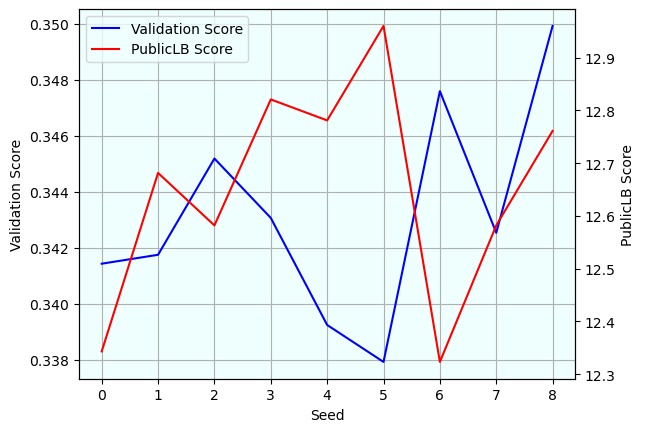

In [49]:
LB_loss_list = [
    12.34328, 
    12.68159, 
    12.58209, 
    12.82090, 
    12.78109, 
    12.96020, 
    12.32338, 
    12.58209, 
    12.76119
    ]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1=ax1.plot(pd.DataFrame(np.array(loss_list), columns=['Score']), label='Validation Score', color='blue')
ax2 = ax1.twinx()
ln2=ax2.plot(pd.DataFrame(np.array(LB_loss_list), columns=['PublicLB Score']), label='PublicLB Score', color='red')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

ax1.grid(True)
ax1.set_xlabel('Seed')
ax1.set_ylabel('Validation Score')
ax2.set_ylabel('PublicLB Score')